In this blog post, I will use the Seaborn "Car Crashes" dataset in order to group similar states together and observe patterns with motor accidents in these states. 

# Get and Examine the Data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.get_dataset_names()
crashes = sns.load_dataset('car_crashes')
crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
4,12.0,4.200,3.360,10.920,10.680,878.41,165.63,CA


We see that this dataset contains various details about accidents, like whether the driver was speeding or intoxicated. There is also the abbrev column, which indicates the state in which the accident took place. 

In [2]:
crashes.shape
crashes[crashes['abbrev'] == "DC"]

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
8,5.9,2.006,1.593,5.9,5.9,1273.89,136.05,DC


The reason there are 51 rows is because the 50 states along with DC are included. Now, let's check for missing or invalid data. 

In [3]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total           51 non-null     float64
 1   speeding        51 non-null     float64
 2   alcohol         51 non-null     float64
 3   not_distracted  51 non-null     float64
 4   no_previous     51 non-null     float64
 5   ins_premium     51 non-null     float64
 6   ins_losses      51 non-null     float64
 7   abbrev          51 non-null     object 
dtypes: float64(7), object(1)
memory usage: 3.3+ KB


In [4]:
crashes.isna().any().any()

False

Looks like there is no missing data. We can now perform a few checks on whether the data makes sense. 

In [5]:
crashes['total'].min()
crashes['speeding'].min()
crashes['alcohol'].min()
crashes['not_distracted'].min()
crashes['no_previous'].min()
crashes['ins_premium'].min()
crashes['ins_losses'].min()

82.75

It looks like the data is valid, so we are good to proceed. Let's first visualize the total column for each of the states. To make the barplot less cluttered, let's focus on the 5 states with the highest number of crashes and the 5 states with the lowest number of crashes. 

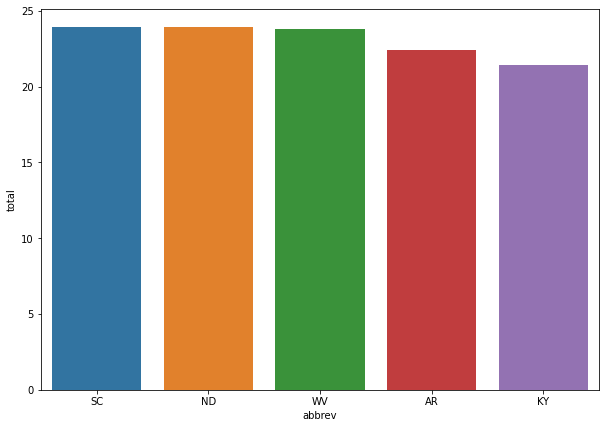

In [6]:
crashes_sorted = crashes.sort_values('total', ascending=False)
crashes_sorted
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(data=crashes_sorted[:5], x='abbrev', y='total', ax=ax)

plt.show()

The states which have the highest number of crashes are South Carolina, North Dakota, West Virginia, Arkansas, and Kentucky. 

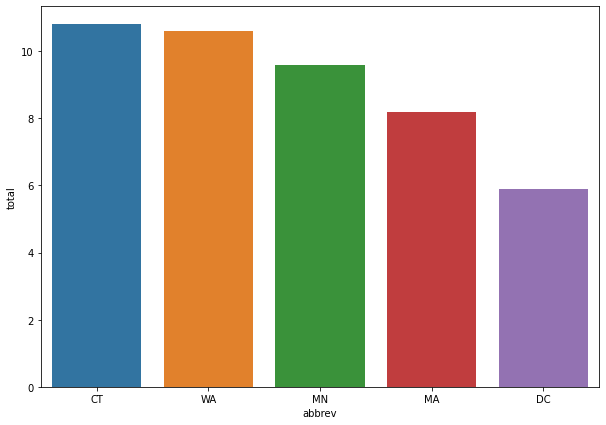

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(data=crashes_sorted[-5:], x='abbrev', y='total')

plt.show()

On the other end of the spectrum, Connecticut, Washington state, Minnesota, Massachussetts, and DC have the fewest crashes. 

# Dimensionality Reduction

We have 7 columns in our dataset, not including the state abbreviation. With so many columns, it is hard to visualize how similar data points are to one another. Therefore, we will need to perform dimensionality reduction before we can visualize similarities between different data points. 

In [8]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)

# Remove the abbreviation column, as it is not helpful in comparing data points. 
crashes_without_abbrev = crashes.set_index('abbrev')
crashes_without_abbrev.loc[:, crashes_without_abbrev.columns != 'abbrev']
crashes_without_abbrev

crashes2D = pca.fit_transform(crashes_without_abbrev)
crashes2D = pd.DataFrame(crashes2D, index=crashes_without_abbrev.index)
pca.components_

array([[-4.58058550e-03, -8.80126113e-04, -1.65125559e-03,
        -4.40130754e-03, -3.28217700e-03,  9.96137961e-01,
         8.74901966e-02],
       [ 2.70673578e-02, -1.44557187e-03,  3.67655984e-04,
         1.27351225e-02,  2.53491114e-02, -8.71636336e-02,
         9.95420953e-01]])

Now, let's see how much of the variance in the data is explained by the first 2 PCA dimensions. 

In [9]:
pca.explained_variance_ratio_

array([0.98671551, 0.01155058])

The first component explains the vast majority of the variance (over 98%), while the second column explains almost all of the remaining variance. 

In [10]:
1 - pca.explained_variance_ratio_.sum()

0.001733914130986669

In fact, only around 0.17% of the variance is not explained by these first two components.  
Now, let's visualize the data using a PCA plot. 

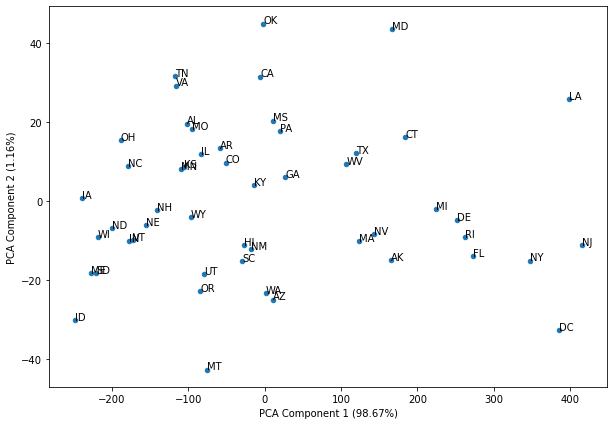

In [11]:
ax = crashes2D.plot.scatter(x=0, y=1, figsize=(10,7))
for ind,row in crashes2D.iterrows():
    ax.text(row[0], row[1], ind)
ax.set_xlabel('PCA Component 1 (98.67%)');
ax.set_ylabel('PCA Component 2 (1.16%)');

The plot above labels the states and plots them according to the two principal components. Even though accident totals is just one dimension, we can see that West Virginia, Arkansas, and Kentucky, three of the states that had high totals, are in the same approximate area.  

Now, let's cluster the states together, using the K-Means algorithm. First, let's try to find the optimal number of clusters. 

## Elbow Curve

Let's draw an elbow curve to visualize how the inertia drops as the number of clusters increases. 

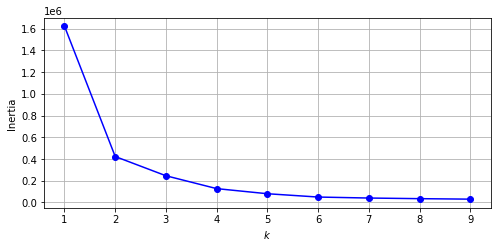

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(crashes_without_abbrev)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$");
plt.ylabel("Inertia");
plt.grid()
plt.show()

From this plot, it appears that in fact k=2 is the inflection point of the graph. Let's also construct a silhouette plot. 

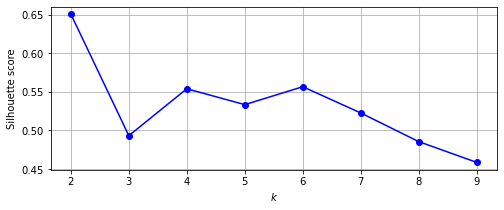

In [13]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(crashes_without_abbrev, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")

plt.grid()
plt.show()

It appears that 2 clusters is the best choice according to both the elbow curve and the silhouette score. There doesn't appear to be a good reason to not choose 2 clusters, so let's proceed with the KMeans algorithm using 2 clusters.  

In [14]:
kmeans = KMeans(n_clusters=2, random_state=42)
y_pred = kmeans.fit_predict(crashes_without_abbrev)
y_pred

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0], dtype=int32)

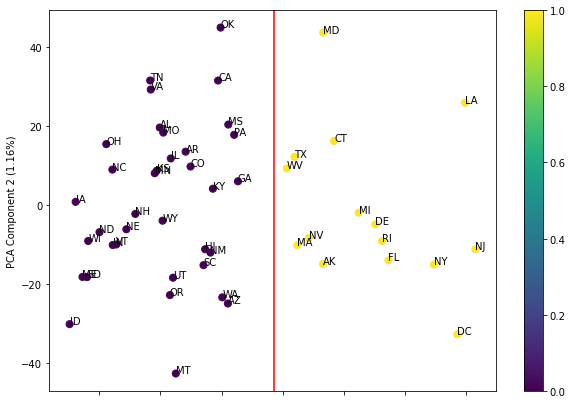

In [15]:
ax = crashes2D.plot.scatter(x=0, y=1, figsize=(10,7), c=y_pred, cmap='viridis', s=50)
for ind,row in crashes2D.iterrows():
    ax.text(row[0], row[1], ind)
ax.set_xlabel('PCA Component 1 (98.67%)');
ax.set_ylabel('PCA Component 2 (1.16%)');
ax.axvline(x=85, color='r')

From this plot, we can see a clear split along PC1. The vertical line on the plot separates the two clusters perfectly. We can see that states to the right of that line belong to one cluster and states to the left of the vertical line lie in the other cluster. Since PC1 explains over 98% of the variance, this approach would make sense.  

# Attributions

1. https://plainenglish.io/blog/9-seaborn-datasets-for-data-science-ml-beginners#3-car-crashes
2. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
3. https://www.geeksforgeeks.org/how-to-set-a-seaborn-chart-figure-size/
